# Use Logistic regression to determine if the asset will give positive or negetive returns tomo

1. Get data
2. Preprocess the data i.e. Add Indicators or Features
3. Perform Logistic Regression
4. Improve the model


In [4]:
import pandas as pd
import numpy as np 
import matplotlib as plt
import warnings 
warnings.filterwarnings('ignore')                     
import datetime as dt
import talib as ta
from get_data import get_data

In [5]:
end= dt.date.today() ; start= end- pd.Timedelta(days= 256*10)

df= get_data('MSFT', start, end)

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,open,high,low,close,volume
Date,,,,,
2016-06-17,50.410000,50.430000,49.820000,45.370064,45710500
2016-06-20,50.639999,50.830002,50.029999,45.315746,35607900
2016-06-21,50.200001,51.430000,50.160000,46.329399,34097800
2016-06-22,51.080002,51.459999,50.950001,46.148407,28816800
2016-06-23,51.279999,52.060001,51.150002,46.981033,29028800


In [28]:
#creating Features for regression
rsi_lb= 7
adx_lb= 7
ma_lb= 5

df['rsi']= ta.RSI(df.close.shift(1), timeperiod= rsi_lb)
df['adx']= ta.ADX(df.high.shift(1), df.low.shift(1),df.close.shift(1), timeperiod= adx_lb)
df['ma']= df.close.shift(1).rolling(ma_lb).mean()
df['corr']= df.close.shift(1).rolling(ma_lb).corr(df.ma.shift(1))


#calculating returns

df['cc_returns']= np.log(df.close/df.open)

# Target Variable

df['direction']= np.where(df.cc_returns >0 ,1, -1)

In [29]:
df.head()

,open,high,low,close,volume,rsi,adx,ma,corr,cc_returns,direction
Date,,,,,,,,,,,
2016-07-08,51.730000,52.360001,51.549999,47.334011,28391000,NaN,NaN,NaN,NaN,-0.088809,-1
2016-07-11,52.500000,52.830002,52.470001,47.596489,22269200,NaN,NaN,NaN,NaN,-0.098054,-1
2016-07-12,52.939999,53.400002,52.790001,48.157608,27317600,NaN,NaN,NaN,NaN,-0.094680,-1
2016-07-13,53.560001,53.860001,53.180000,48.429123,25356800,NaN,NaN,NaN,NaN,-0.100701,-1
2016-07-14,53.840000,53.990002,53.580002,48.637283,24545500,NaN,NaN,NaN,NaN,-0.101626,-1


In [30]:
df.dropna(inplace=True) #Dropping all the NAN values

In [31]:
df.isna().sum() #confirming there is no NAN value

open          0
high          0
low           0
close         0
volume        0
rsi           0
adx           0
ma            0
corr          0
cc_returns    0
direction     0
dtype: int64

In [32]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [33]:
X= df[['rsi','adx','ma','corr']] # Creating Feature set
y= df['direction']  #Creating Target

In [34]:
X_train,X_test, y_train, y_test= train_test_split(X,y,test_size= .2,random_state=15) # Splitting the data into train and test set

In [35]:
steps= [('scaler',StandardScaler()),('logreg',LogisticRegression())] # defining steps to be used in pipeline
pipeline= Pipeline(steps) #initializing the pipeline

In [36]:
# Define the hyperparameter search space
parameters = {
    'logreg__C': [0.1, 1.0, 10.0],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'lbfgs', 'saga']
}

In [37]:
model= GridSearchCV(pipeline, parameters, cv= TimeSeriesSplit(n_splits=5)) # Initialize the model

In [38]:
model.fit(X_train,y_train) #Fit the training data into the model

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.1, 1.0, 10.0],
                         'logreg__penalty': ['l1', 'l2'],
                         'logreg__solver': ['liblinear', 'lbfgs', 'saga']})

In [39]:
hyperparameters= model.best_params_ # out of all the hyperparameters check which parameters were best
print(hyperparameters)

{'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [40]:
model.best_score_ #best score is the average accuracy the model was able to achive on training data

0.9090909090909092

In [41]:
final_model= LogisticRegression(C= hyperparameters['logreg__C'],  penalty= hyperparameters['logreg__penalty'], solver= hyperparameters['logreg__solver']) 
#now we make the final model with the best hypermaters we found

In [42]:
final_model.fit(X_train,y_train) # fitting the training data into the model

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [43]:
y_pred=final_model.predict(X_test) # predicting the market direction using the test features and storing the results ina vsriable for comparision

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score

In [45]:
accuracy= accuracy_score(y_test, y_pred) #checking the accuracy of test target and predicted values
print(accuracy)

0.8904899135446686


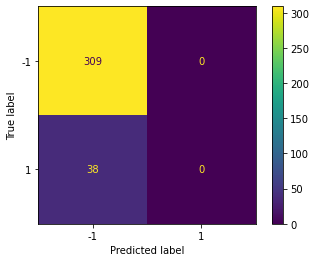

In [46]:
plot_confusion_matrix(final_model,X_test,y_test) #plotting the confusion matrix

In [47]:
df

,open,high,low,close,volume,rsi,adx,ma,corr,cc_returns,direction
Date,,,,,,,,,,,
2016-07-28,56.000000,56.369999,55.720001,50.872749,37550400,72.472357,63.647301,51.053763,0.284445,-0.096024,-1
2016-07-29,56.259998,56.759998,56.049999,51.298119,30558700,72.649721,60.209695,51.127975,-0.726706,-0.092330,-1
2016-08-01,56.599998,56.750000,56.139999,51.207630,26003400,76.756540,58.261009,51.147884,-0.630904,-0.100120,-1
2016-08-02,56.849998,56.900002,56.310001,51.207630,35122000,73.998868,56.590707,51.120735,-0.440021,-0.104528,-1
2016-08-03,56.680000,57.110001,56.490002,51.560596,22075600,73.998868,55.594637,51.088156,0.926890,-0.094664,-1
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,334.470001,336.980011,330.390015,334.290009,22951300,60.615430,30.706992,328.192004,-0.389048,-0.000538,-1
2023-06-14,334.339996,339.040009,332.809998,337.339996,26003800,64.463148,30.343308,328.314008,-0.984094,0.008933,1
2023-06-15,337.480011,349.839996,337.200012,348.100006,38899100,68.894793,30.954502,331.106006,-0.942971,0.030984,1


In [48]:
df.direction.value_counts()

-1    1576
 1     159
Name: direction, dtype: int64

In [49]:
y_test.value_counts()

-1    309
 1     38
Name: direction, dtype: int64

<AxesSubplot:xlabel='Date'>

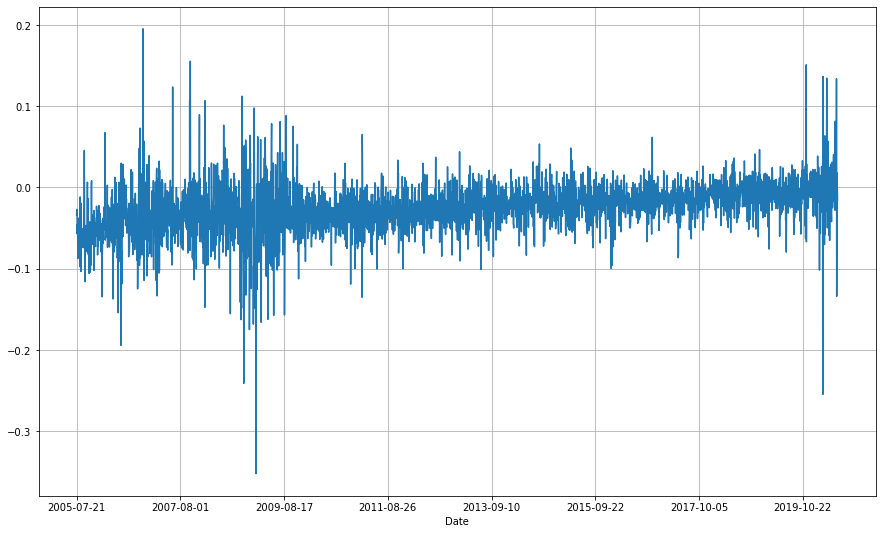

In [194]:
df.cc_returns.plot(figsize=(15,9), grid=True)